In [25]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import functools

from itertools import combinations
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torch.distributions.categorical import Categorical

device = torch.device("cpu")
plt.rcParams['mathtext.fontset'] = 'stix'

### Full length AIB9 trajectory at 500K (4M, 200ns) without discretization

In [26]:
infile = './../../DATA/Train/AIB9/sum_phi_200ns.npy'
input_x = np.load(infile)

In [27]:
bins=np.arange(-15., 17, 1)
num_bins=len(bins)
idx_input_x=np.digitize(input_x, bins)

In [28]:
print('\u0332'.join('KAPPA '))

N0=len(np.where(idx_input_x<=15)[0])
N1=len(np.where(idx_input_x>=16)[0])
kappa_in=N0/N1
print('Input: {:.3f}, corresponding to input trajectory of 20ns'.format(kappa_in))

K̲A̲P̲P̲A̲ 
Input: 1.149, corresponding to input trajectory of 20ns


### Discretized AIB9 trajectory of 400k, 20ns

In [29]:
infile = '../../DATA/Train/AIB9/idx_sum_phi_20ns.npy'
idx_input_x1 = np.load(infile)

In [30]:
print('\u0332'.join('KAPPA '))

N0=len(np.where(idx_input_x1<=15)[0])
N1=len(np.where(idx_input_x1>=16)[0])
kappa_in=N0/N1
print('Input: {:.3f}, corresponding to input trajectory of 20ns'.format(kappa_in))

K̲A̲P̲P̲A̲ 
Input: 0.478, corresponding to input trajectory of 20ns


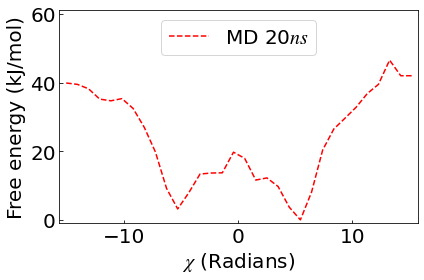

In [31]:
# data
T = 500 # unit: K
beta = 1000/(T*8.28) # kT=(8.28/1000)*T (kJ/mol/K)

hist_200ns = np.histogram(input_x, bins=32)
prob_200ns = hist_200ns[0].T/np.sum(hist_200ns[0].T)
freeE_200ns = (-1/beta)*np.log(prob_200ns-1e-11)
mids_200ns = 0.5*(hist_200ns[1][1:]+hist_200ns[1][:-1])

hist_20ns = np.histogram(input_x[:400000], bins=32)
prob_20ns = hist_20ns[0].T/np.sum(hist_20ns[0].T)
freeE_20ns = (-1/beta)*np.log(prob_20ns-1e-11)
mids_20ns = 0.5*(hist_20ns[1][1:]+hist_20ns[1][:-1])

# plotting
fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

# ax.plot(mids_200ns, freeE_200ns-np.min(freeE_200ns), linestyle='--', color='red', label='MD 200$ns$')
ax.plot(mids_20ns, freeE_20ns-np.min(freeE_20ns), linestyle='--', color='red', label='MD 20$ns$')

ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlabel('$\chi$ (Radians)', size=20)
ax.set_ylabel('Free energy (kJ/mol)', size=20)
ax.set_xlim(-np.pi*5, np.pi*5)
ax.set_ylim(-1, 61)
ax.legend(loc='upper center', fontsize=20)

fig.tight_layout()
# plt.savefig('input.pdf', format='pdf', dpi=300, pad_inches = 0.05)

plt.show()

### Longer prediction using second training

In [32]:
pred2={}
for i in range(10):
    pdfile = './Output-conc/{}/prediction.npy'.format(i)
    prediction2 = np.load(pdfile)
    pred2[i]=prediction2

In [33]:
kappa_pred2=[]

for i in range(10):

    N0=len(np.where(pred2[i]<=15)[0])
    N1=len(np.where(pred2[i]>=16)[0])
    kappa=N0/N1
    kappa_pred2.append( kappa )
    
print( np.mean(kappa_pred2) )
print( np.std(kappa_pred2)/np.sqrt(len(kappa_pred2)) )

1.2087126902831653
0.14291425364441127


### Longer prediction using first training

In [34]:
pred1={}
for i in range(10):
    pdfile = './Output-long/{}/prediction.npy'.format(i)
    prediction1 = np.load(pdfile)
    pred1[i]=prediction1

In [12]:
kappa_pred1=[]

for i in range(10):

    N0=len(np.where(pred1[i]<=15)[0])
    N1=len(np.where(pred1[i]>=16)[0])
    kappa=N0/N1
    kappa_pred1.append( kappa )
    
print( np.mean(kappa_pred1) )
print( np.std(kappa_pred1)/np.sqrt(len(kappa_pred1)) )

0.8671529330647356
0.3853655720444007


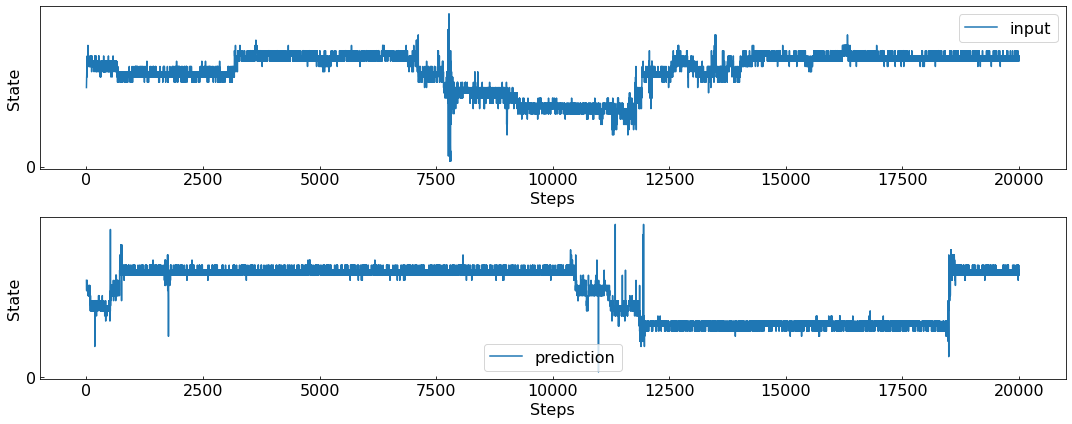

In [35]:
fig, ax = plt.subplots(figsize=(15,2*3), nrows=2, ncols=1)

ax[0].plot(idx_input_x1[:20000], label='input')
ax[0].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[0].set_yticks(np.arange(0,1,1))
ax[0].set_xlabel('Steps', size=16)
ax[0].set_ylabel('State', size=16)
ax[0].legend(fontsize=16)

for i in range(1):
    ax[i+1].plot(pred2[i][:20000], label='prediction')
    ax[i+1].tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax[i+1].set_yticks(np.arange(0,1,1))
    ax[i+1].set_xlabel('Steps', size=16)
    ax[i+1].set_ylabel('State', size=16)
    ax[i+1].legend(fontsize=16)

fig.tight_layout()
plt.show()

# Eigenspectrum

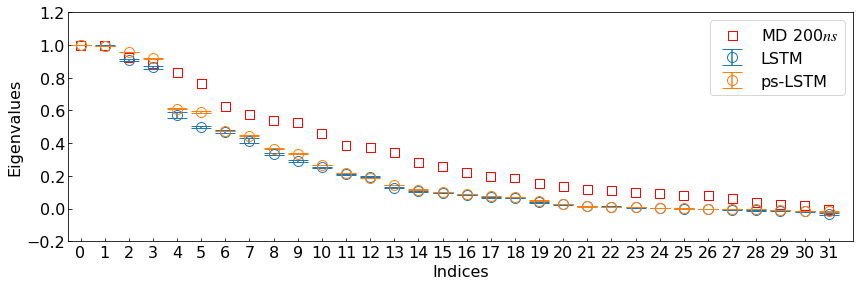

In [49]:
def eigendecompose(transmat):
    
    eigenValues, eigenVectors = np.linalg.eig(transmat)
    idx = eigenValues.real.argsort()[::-1]               # Sorting by eigenvalues
    eigenValues = eigenValues[idx]                       # Order eigenvalues
    eigenVectors = eigenVectors[:,idx]                   # Order eigenvectors
    
    return eigenValues.real, eigenVectors.real

# Input
hist_x = np.histogram2d(input_x[:-1], input_x[1:], bins=32) # (old, new)
trans_pi = hist_x[0]/hist_x[0].sum(axis=1, keepdims=True)

eval_pi, evec_pi = eigendecompose(trans_pi)

# After second training
eval_p2_arr=[]
for i in range(10):
    hist_p2 = np.histogram2d(pred2[i][:-1], pred2[i][1:], bins=32) # (old, new)
    trans_pp2 = hist_p2[0]/hist_p2[0].sum(axis=1, keepdims=True)

    eval_pp2, evec_pp2 = eigendecompose(trans_pp2)
    
    eval_p2_arr.append(eval_pp2)

mean_eval_p2, stdv_eval_p2 = np.mean(eval_p2_arr, axis=0), np.std(eval_p2_arr, axis=0)/np.sqrt(10)

# After first training
eval_p1_arr=[]
for i in range(10):
    hist_p1 = np.histogram2d(pred1[i][:-1], pred1[i][1:], bins=32) # (old, new)
    trans_pp1 = hist_p1[0]/hist_p1[0].sum(axis=1, keepdims=True)

    eval_pp1, evec_pp1 = eigendecompose(trans_pp1)
    
    eval_p1_arr.append(eval_pp1)

mean_eval_p1, stdv_eval_p1 = np.mean(eval_p1_arr, axis=0), np.std(eval_p1_arr, axis=0)/np.sqrt(10)


fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(np.arange(len(eval_pi)), eval_pi, s=80, marker='s', facecolor='none', edgecolor='r', label='MD 200$ns$')
ax.errorbar(np.arange(32), mean_eval_p1, yerr=stdv_eval_p1, fmt='o', fillstyle='none', markersize=10, capsize=10, label='LSTM')
ax.errorbar(np.arange(32), mean_eval_p2, yerr=stdv_eval_p2, fmt='o', fillstyle='none', markersize=10, capsize=10, label='ps-LSTM')

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('Indices', size=16)
ax.set_ylabel('Eigenvalues', size=16)

ax.set_xticks(np.arange(32))

ax.set_xlim(-0.5,32)
ax.set_ylim(-0.2, 1.2)
ax.legend(loc='upper right', fontsize=16)

fig.tight_layout()
# plt.savefig('eigenspectrum_kappa.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()

In [37]:
def compute_kappa_N_mean(pred):

    kappa_arr = []
    for i in range(10):

        N0=len(np.where(pred[i]<=15)[0])
        N1=len(np.where(pred[i]>=16)[0])
        kappa_i = N0/N1

        kappa_arr.append(kappa_i)
        
    return kappa_arr
        
# Second training
kappa2_arr = compute_kappa_N_mean(pred2)
# First training
kappa1_arr = compute_kappa_N_mean(pred1)

print("Second training:")
print("Mean kappa: ", np.mean(kappa2_arr), "; Stdv kappa: ", np.std(kappa2_arr)/np.sqrt(10))

print("First training:")
print("Mean kappa: ", np.mean(kappa1_arr), "; Stdv kappa: ", np.std(kappa1_arr)/np.sqrt(10))

Second training:
Mean kappa:  1.2087126902831653 ; Stdv kappa:  0.14291425364441127
First training:
Mean kappa:  0.8671529330647356 ; Stdv kappa:  0.3853655720444007


In [38]:
T = 500 # unit: K
beta = 1000/(T*8.28) # kT=(8.28/1000)*T (kJ/mol/K)

bins=np.arange(-15., 17, 1)
num_bins=len(bins)
idx_input_x=np.digitize(input_x, bins)

hist0=np.histogram(idx_input_x, bins=32)
prob0=hist0[0].T/np.sum(hist0[0].T)
freeE0=(-1/beta)*np.log(prob0+1e-11)
mids0=0.5*(hist0[1][1:]+hist0[1][:-1])

freeE1={}
for i in range(10):
    hist1=np.histogram(pred1[i], bins=32)
    prob1=hist1[0].T/np.sum(hist1[0].T)
    freeE1[i]=(-1/beta)*np.log(prob1+1e-11)
    mids1=0.5*(hist1[1][1:]+hist1[1][:-1])
    
freeE2={}
for i in range(10):
    hist2=np.histogram(pred2[i], bins=32)
    prob2=hist2[0].T/np.sum(hist2[0].T)
    freeE2[i]=(-1/beta)*np.log(prob2+1e-11)
    mids2=0.5*(hist2[1][1:]+hist2[1][:-1])

### How to convert the bin label back to RC?

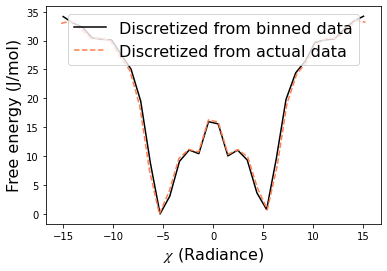

In [39]:
hist00 = np.histogram(input_x, bins=32)
prob00 = hist00[0].T/np.sum(hist00[0].T)
freeE00 = (-1/beta)*np.log(prob00-1e-11)
mids00 = 0.5*(hist00[1][1:]+hist00[1][:-1])

fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

ax.plot(mids0-15.5, freeE0-np.min(freeE0), linestyle='-', color='black', label='Discretized from binned data')
ax.plot(mids00, freeE00-np.min(freeE00), linestyle='--', color='coral', label='Discretized from actual data')


ax.set_xlabel('$\chi$ (Radiance)', size=16)
ax.set_ylabel('Free energy (J/mol)', size=16)
ax.legend(loc='upper center', fontsize=16)

plt.show()

### compared with prediction by different training methods

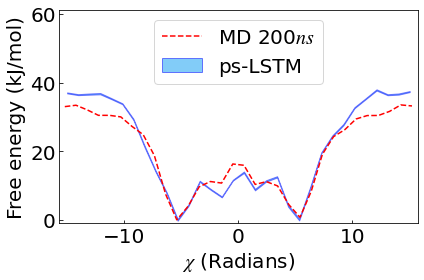

In [40]:
freeE2_arr = np.array(list(freeE2.values()))
mean_freeE2=np.mean(freeE2_arr, axis=0)
stdv_freeE2=np.std(freeE2_arr, axis=0)/np.sqrt(len(freeE2_arr))

fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

ax.plot(mids_200ns, freeE_200ns-np.min(freeE_200ns), linestyle='--', color='red', label='MD 200$ns$')

# ax.errorbar(mids2-15.5, mean_freeE2-np.min(mean_freeE2), yerr=stdv_freeE2, linestyle='--', color='coral', capsize=3, label='ps-LSTM')
ax.fill_between(mids2-15.5, mean_freeE2-np.min(mean_freeE2)-stdv_freeE2, mean_freeE2-np.min(mean_freeE2)+stdv_freeE2, label='ps-LSTM',
                alpha=0.5, edgecolor='blue', facecolor='#069AF3')

ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlabel('$\chi$ (Radians)', size=20)
ax.set_ylabel('Free energy (kJ/mol)', size=20)
ax.set_xlim(-np.pi*5, np.pi*5)
ax.set_ylim(-1, 61)
ax.legend(loc='upper center', fontsize=20)

fig.tight_layout()
plt.savefig('training2.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()

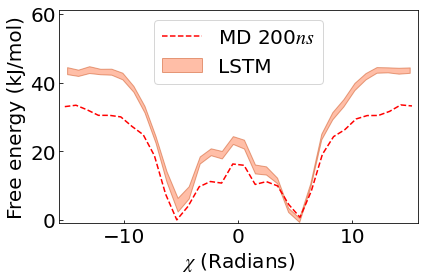

In [41]:
freeE1_arr = np.array(list(freeE1.values()))
mean_freeE1=np.mean(freeE1_arr, axis=0)
stdv_freeE1=np.std(freeE1_arr, axis=0)/np.sqrt(len(freeE1_arr))

fig, ax=plt.subplots(figsize=(6,4), nrows=1, ncols=1)

ax.plot(mids_200ns, freeE_200ns-np.min(freeE_200ns), linestyle='--', color='red', label='MD 200$ns$')

# ax.errorbar(mids1-15.5, mean_freeE1-np.min(mean_freeE1), yerr=stdv_freeE1, linestyle='--', color='coral', capsize=3, label='LSTM')
ax.fill_between(mids1-15.5, mean_freeE1-np.min(mean_freeE1)-stdv_freeE1, mean_freeE1-np.min(mean_freeE1)+stdv_freeE1, label='LSTM',
                alpha=0.5, edgecolor='#CC4F1B', facecolor='coral')

ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlabel('$\chi$ (Radians)', size=20)
ax.set_ylabel('Free energy (kJ/mol)', size=20)
ax.set_xlim(-np.pi*5, np.pi*5)
ax.set_ylim(-1, 61)
ax.legend(loc='upper center', fontsize=20)

fig.tight_layout()
plt.savefig('training1.pdf', format='pdf', dpi=300, pad_inches = 0.05)
plt.show()